In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
from datetime import datetime, timedelta, date
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import r2_score

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import keras.backend as K
from keras import layers
from keras.initializers import Zeros
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.layers import Dropout

# Set random seed
np.random.seed(0)

def adj_r2_score(r2, n, k):
    return 1 - ((1 - r2) * ((n - 1) / (n - k - 1)))

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Set figure size for all matplotlib figures
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 5

In [3]:
df = pd.read_excel('/content/DEXINUS.xls',
                   skiprows=10,
                   index_col=[0],
                   parse_dates=True)
df.head()

,DEXINUS
observation_date,
1973-01-02,8.02
1973-01-03,8.02
1973-01-04,8.00
1973-01-05,8.01
1973-01-08,8.00


In [4]:
#Fill missing values using interpolation
df['DEXINUS'].interpolate(method='linear',
                          limit_direction='forward',
                          inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12649 entries, 1973-01-02 to 2021-06-25
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   DEXINUS  12649 non-null  float64
dtypes: float64(1)
memory usage: 197.6 KB


In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df)
data1 = scaler.transform(df)
data1

array([[0.01189794],
       [0.01189794],
       [0.01161124],
       ...,
       [0.95957569],
       [0.95971904],
       [0.95971904]])

In [7]:
data3 = list(data1[12649-7431:].reshape(7431))
len(data3)

7431

In [8]:
def gen_XY(t_list, size):
    '''
    Generates an autoregressive lagged array.
    
    Parameters
    ----------
    1. t_list: (list) Data to generate an autoregressive array out of.
    2. size: (int) Number of lagged values to consider.
    
    Returns
    ----------
    1. X: (np.ndarray) Autoregressive feature array.
    2. Y.T: (np.ndarray) Column array with values of response variable.
    
    '''
    X = np.zeros([1, size])
    Y = []
    temp_list = []
    for i in range(len(t_list) - size):
        add_list = t_list[i:i + size]
        target = t_list[i + size]
        X = np.append(X, np.array([add_list]), axis=0)
        Y.append(target)

    X = np.delete(X, 0, axis=0)
    Y = np.array(Y)

    return X, Y.T

In [9]:
X_train3, y_train3 = gen_XY(data3, 1)

In [10]:
print(y_train3.shape,X_train3.shape,type(y_train3))
print(y_train3[:5])
# print(y_train.reshape(12123,-1))

(7430,) (7430, 1) <class 'numpy.ndarray'>
[0.31264335 0.31264335 0.31264335 0.31264335 0.31264335]


In [11]:
#LSTM Preprocessing
X_tr_t3 = X_train3.reshape(X_train3.shape[0], 1, X_train3.shape[1])
print(X_tr_t3.shape)
X_tr_t3[:2]

(7430, 1, 1)


array([[[0.31264335]],

       [[0.31264335]]])

In [12]:
from keras.layers import LSTM

K.clear_session()
model_lstm = Sequential()
model_lstm.add(
    LSTM(100,
         input_shape=(1,X_train3.shape[1]),
         activation='relu',
#          kernel_initializer='lecun_uniform',
         return_sequences=False))
model_lstm.add(Dense(1))
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [13]:
model_lstm.compile(
    loss=tf.keras.metrics.mean_squared_error,
    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')],
    optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)
history_model_lstm = model_lstm.fit(X_tr_t3,
                                    y_train3,
                                    epochs=100,
                                    batch_size=1,
                                    verbose=1,
                                    shuffle=False,
                                    callbacks=[early_stop])

Epoch 1/100
7430/7430 [==============================] - 38s 2ms/step - loss: 0.0041 - rmse: 0.0871
Epoch 2/100
7430/7430 [==============================] - 13s 2ms/step - loss: 5.3118e-04 - rmse: 0.0254
Epoch 3/100
7430/7430 [==============================] - 14s 2ms/step - loss: 5.8763e-04 - rmse: 0.0199
Epoch 00003: early stopping


In [14]:
def MAPE(y,yhat):
    return np.mean(np.abs((y - yhat)/y)*100)

# y_pred_test_lstm = scaler.inverse_transform(model_lstm.predict(X_tst_t))
y_train_pred_lstm = scaler.inverse_transform(model_lstm.predict(X_tr_t3))
iy_train = scaler.inverse_transform(y_train3.reshape(7430,-1))#3519
# iy_test = scaler.inverse_transform(y_test.reshape(524,-1))

train_mse = metrics.mean_squared_error(iy_train, y_train_pred_lstm)
rmse_train = np.sqrt(train_mse)


print('The Scores on Train Data')
print('-----------------------')
print("The R2 score on the Train set is           :\t{:0.3f}".format(
    r2_score(iy_train, y_train_pred_lstm)))
print("The  MAE on the Train set is               :\t{:0.3f}".format(
    metrics.mean_absolute_error(iy_train, y_train_pred_lstm)))

print("The  RMSE on the Train set is              :\t{:0.3f}".format(rmse_train))
r2_train = r2_score(iy_train, y_train_pred_lstm)
print("The Adjusted R2 score on the Train set is  :\t{:0.3f}".format(
    adj_r2_score(r2_train, X_train3.shape[0], X_train3.shape[1])))
print('The MAPE on Train set is                   :\t{:.3f} %\n'.format(MAPE(iy_train,y_train_pred_lstm)))


The Scores on Train Data
-----------------------
The R2 score on the Train set is           :	-0.085
The  MAE on the Train set is               :	11.560
The  RMSE on the Train set is              :	12.959
The Adjusted R2 score on the Train set is  :	-0.086
The MAPE on Train set is                   :	27.706 %



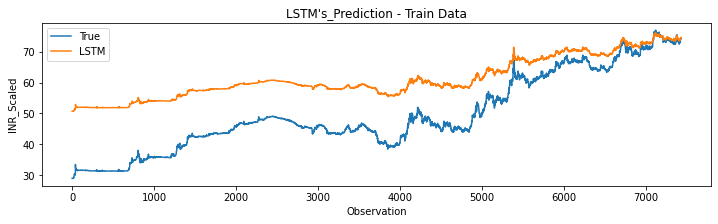

In [15]:
plt.figure(figsize=(12, 3))
plt.plot(iy_train, label='True')
plt.plot(y_train_pred_lstm, label='LSTM')
plt.title("LSTM's_Prediction - Train Data")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

In [16]:
x_input=np.array(data3[7431-1:]).reshape(1,-1)
print(x_input.shape,'\n')
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
temp_input

(1, 1) 



[0.9597190366972478]

In [17]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=1
i=0
while(i<30):
    
    if(len(temp_input)>1):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        # print("{} day input {}".format(i,x_input))
        # x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, 1, n_steps))
        # print(x_input)
        yhat = model_lstm.predict(x_input, verbose=0)
        # print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape(1,1,n_steps,)
        print(x_input)
        yhat = model_lstm.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        # print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[[0.95971904]]]
[[0.9643537402153015], [0.9669992923736572], [0.9685108065605164], [0.9693748950958252], [0.9698688387870789], [0.9701513648033142], [0.9703129529953003], [0.9704053401947021], [0.9704582691192627], [0.970488429069519], [0.9705056548118591], [0.9705156087875366], [0.9705213308334351], [0.9705245494842529], [0.9705264568328857], [0.9705275297164917], [0.9705280661582947], [0.9705284833908081], [0.9705286622047424], [0.970528781414032], [0.9705288410186768], [0.9705289602279663], [0.9705290198326111], [0.9705290198326111], [0.9705290198326111], [0.9705290198326111], [0.9705290198326111], [0.9705290198326111], [0.9705290198326111], [0.9705290198326111]]


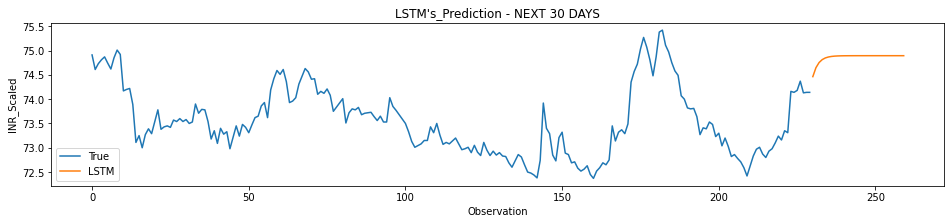

In [18]:
day_pred=np.arange(230,260)
plt.figure(figsize=(16, 3))
plt.plot(iy_train[7200:], label='True')
plt.plot(day_pred,scaler.inverse_transform(lst_output), label='LSTM')
plt.title("LSTM's_Prediction - NEXT 30 DAYS")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

In [21]:
print('PREDICTED VALUES FOR NEXT 30 DAYS')
print('--------------------------------\n')
result = scaler.inverse_transform(lst_output)
# for i in range(len(lst_output)):
for x in result:
  print(x, sep = ', ' )

PREDICTED VALUES FOR NEXT 30 DAYS
--------------------------------

[74.46331692]
[74.64787064]
[74.75331387]
[74.81359268]
[74.84805019]
[74.86775921]
[74.8790316]
[74.88547653]
[74.88916885]
[74.89127281]
[74.89247448]
[74.89316887]
[74.89356804]
[74.89379257]
[74.89392563]
[74.89400047]
[74.8940379]
[74.894067]
[74.89407948]
[74.89408779]
[74.89409195]
[74.89410027]
[74.89410442]
[74.89410442]
[74.89410442]
[74.89410442]
[74.89410442]
[74.89410442]
[74.89410442]
[74.89410442]
